In [1]:
import xarray as xr
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import matplotlib.patches as mpatches
import cmocean as cmo
import numpy as np
import cartopy.crs as ccrs
import cartopy
import pandas as pd
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib.ticker as mticker
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
from scipy.interpolate import griddata
from scipy.io import loadmat
import datetime
# from datetime import datetime
import string

import sys
sys.path.append("./")  # adds upper level to working directory\n
from utils_iohc_ummenhofer2020 import deseason,ohc_anomaly,cut_indo,plot_map,finished_plot,add_ipo_bar,monte_carlo

# where to save plots
plotsave = 'plots/'
datapath = '/vortexfs1/share/clidex/data/'

In [2]:
# baseline period for anomalies
base = ['1960-01-01','2012-12-31'] # paper

# values for heat content calculation
cp = 3994 # heat capacity
rho = 1029 # reference density
# cp and rho from https://xgcm.readthedocs.io/en/latest/example_eccov4.html

# masks
masktype = 'orca' # 'levitus'

if masktype=='orca': mask = xr.open_dataset(datapath+'ORCA/mesh_files/new_maskglo.nc')
elif masktype=='levitus': mask = xr.open_dataset('./data/mask_ind_levitus_orca.nc')

# Load data

In [3]:
################### load data ######################
zrange = slice(0,22)  #3m-734m for temp data
datapath2 = datapath+'publications/IOHC_Ummenhofer/'
k003 = xr.open_dataset(datapath2 + 'K003.hindcast_temp_IndoPacific_30E_150W_70S_30N.nc',
                      chunks={'x': 200, 'y': 200, 'time_counter': 200}).isel(deptht=zrange)
k004 = xr.open_dataset(datapath2 + 'K004.thermhal90_temp_IndoPacific_30E_150W_70S_30N.nc',
                     chunks={'x': 200, 'y': 200, 'time_counter': 200}).isel(deptht=zrange)
k005 = xr.open_dataset(datapath2 + 'K005.wind90_temp_IndoPacific_30E_150W_70S_30N.nc',
                      chunks={'x': 200, 'y': 200, 'time_counter': 200}).isel(deptht=zrange)


###############################################################################
############################# load mask ########################################
###############################################################################
# load mask
%timeit
# rename dimesion to match
mask_orca = mask.rename({'X':'x', 'Y':'y'}).drop(['x','y'])
# cut out indo region
mask_orca = cut_indo(mask_orca['tmaskind']).to_dataset()

###############################################################################
############################ load mesh variables ###############################
###############################################################################

# horizontal 
meshpath = datapath+'ORCA/mesh_files/'
mesh = xr.open_dataset(meshpath + 'mesh_hgr.nc').sel(z=zrange)
# spatical weights (e1t=zonal, e2t=meridional)
e2t = mesh['e2t']
e2t = e2t.rename({'t':'time_counter'}).squeeze()
e1t = mesh['e1t']
e1t = e1t.rename({'t':'time_counter'}).squeeze()

# vertical
mesh = xr.open_dataset(meshpath + 'mesh_zgr.nc').sel(z=zrange)
# vertical weight
e3t = mesh['e3t_0']
e3t = e3t.rename({'t':'time_counter', 'z':'deptht'})
e3t = e3t.squeeze()

# also need to cut weights for multiplication
w3 = cut_indo(e3t).to_dataset()
w3["deptht"] = k003['deptht']
w2 = cut_indo(e2t)
w1 = cut_indo(e1t)
# temperature mask (not sure what this does exactly)
tmask = xr.open_dataset(meshpath + 'mask.nc')['tmask'].isel(z=zrange)
tmask = cut_indo(tmask)
tmask = np.squeeze(tmask.rename({'z':'deptht'}))

# Vertically integrate OHC

In [4]:
# mask_full = xr.ones_like(k003['votemper'][0,0,::]).to_dataset()
# mask_full = mask_full.rename({'votemper':'tmaskind'}).load()
# mask_full = mask_full*tmask[0,::].values

# weights = w3['e3t_0'].values * tmask 
# ohc_k003_700 = ohc_anomaly(k003['votemper'],mask_full,weights=weights,dims=['deptht'],base=base)
# ohc_k004_700 = ohc_anomaly(k004['votemper'],mask_full,weights=weights,dims=['deptht'],base=base)
# ohc_k005_700 = ohc_anomaly(k005['votemper'],mask_full,weights=weights,dims=['deptht'],base=base)

# load saved files
datapath2 = datapath+'publications/IOHC_Ummenhofer/'
ohc_k003_700 = deseason(xr.open_dataset(datapath2+'k003_ohc_zint_700m.nc'),refperiod=base)['votemper'].sel(y=slice(200,None))
ohc_k004_700 = deseason(xr.open_dataset(datapath2+'k004_ohc_zint_700m.nc'),refperiod=base)['votemper'].sel(y=slice(200,None))
ohc_k005_700 = deseason(xr.open_dataset(datapath2+'k005_ohc_zint_700m.nc'),refperiod=base)['votemper'].sel(y=slice(200,None))

# Monte Carlo for significance

Because last panel consists of different number of years we need to run monte-carlo simulation multiple times

In [20]:
# # two-tailed 90% significance
# years=[10,7,3]
# k003_p5 = {}
# k004_p5 = {}
# k005_p5 = {}
# k004_k005_p5 ={}
# k003_p95 = {}
# k004_p95 = {}
# k005_p95 = {}
# k004_k005_p95 = {}

# for yy in years:
#     [k003_p5[str(yy)+'yr'],k003_p95[str(yy)+'yr']] = monte_carlo(ohc_k003_700,duration=yy*12,n=1000,pval=5,timevar='time_counter')
#     [k004_p5[str(yy)+'yr'],k004_p95[str(yy)+'yr']] = monte_carlo(ohc_k004_700,duration=yy*12,n=1000,pval=5,timevar='time_counter')
#     [k005_p5[str(yy)+'yr'],k005_p95[str(yy)+'yr']] = monte_carlo(ohc_k005_700,duration=yy*12,n=1000,pval=5,timevar='time_counter')
#     [k004_k005_p5[str(yy)+'yr'],k004_k005_p95[str(yy)+'yr']] = monte_carlo(ohc_k004_700+ohc_k005_700,
#                                                                            duration=yy*12,n=1000,pval=5,timevar='time_counter')

# # save each dictionary to separate file
# for dic,name in zip([k003_p95,k003_p5,k004_p95,k004_p5,k005_p95,k005_p5,k004_k005_p95,k004_k005_p5],
#                     ['k003_p95','k003_p5','k004_p95','k004_p5','k005_p95','k005_p5','k004_k005_p95','k004_k005_p5']):
#     np.savez('./data/fig3_' + name + '_two_tail_90p_base_1960_2012_n1000',**dic)


##########
# save files will be loaded during plotting

# Plotting

## No stippling - much faster

Text(0.5, 1.3, 'buoyancy+wind')

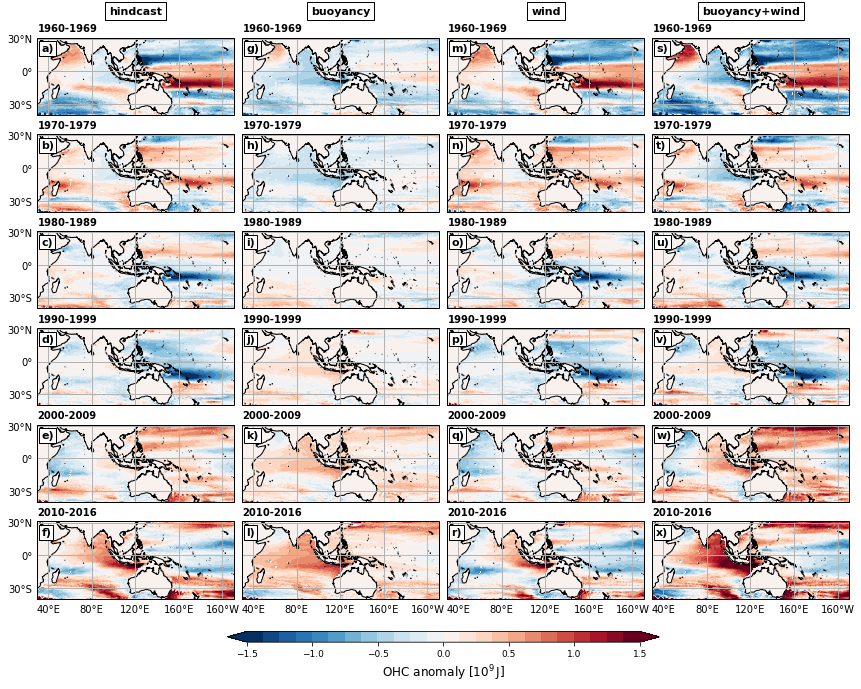

In [7]:
plt.rcParams.update({'font.size': 12})
fig,ax=plt.subplots(nrows=6,ncols=4,figsize=(12,10),
                  subplot_kw = dict(projection=ccrs.PlateCarree(central_longitude=120)))
plt.subplots_adjust(bottom=0.1, top=0.9, left=0.03, right=0.97, wspace=0.04, hspace=0.05)

vmin=-1.5
vmax=1.5
cmap = plt.get_cmap('RdBu_r',len(np.arange(-1.2,1.2,0.1)))

# loop over datasets and plot
j=0
ll = 0
for ds in [ohc_k003_700,ohc_k004_700,ohc_k005_700,ohc_k004_700+ohc_k005_700]:
    # loop over time
    jj = 0
    for year in np.arange(1960,2020,10):
        year2 = year+9
        #print(year,year2)
        time_bnds = [str(year) + '-01-01',str(year2) + '-12-31']
        
        hh = ax[jj,j].pcolormesh(ds.nav_lon,ds.nav_lat,(ds/1e09).sel(time_counter=slice(*time_bnds)).mean('time_counter'),
                       transform=ccrs.PlateCarree(),cmap=cmap,vmin=vmin,vmax=vmax)

        ax[jj,j].gridlines(crs=ccrs.PlateCarree(),draw_labels=False,
                           xlocs=[40,80,120,160,200,-160],ylocs=range(-60,60,30))
        ax[jj,j].coastlines(resolution='50m')
        ax[jj,j].add_feature(cartopy.feature.LAND, color='lightgray')
        ax[jj,j].set_title(str(year) + '-' + str(year2),fontsize=10,loc='left',weight='bold')
        ax[jj,j].tick_params(axis="x", direction="out")
        ax[jj,j].tick_params(axis="y",direction="out")
#         ax[jj,j].set_extent((30,211,-40,31),crs=ccrs.PlateCarree())
        ax[jj,j].set_extent((30,211,-40,31),crs=ccrs.PlateCarree())

        ############ adjust labels for subplots #########################
        gl = ax[jj,j].gridlines(crs=ccrs.PlateCarree(),draw_labels=True,
                        xlocs=[40,80,120,160,-160],ylocs=range(-60,60,30))
        gl.ylabels_right = False
        gl.xlabels_top = False
        # ylabels
        if j==0:
            gl.yformatter = LATITUDE_FORMATTER
            gl.ylabel_style = {'size':10}
        else:
            gl.ylabels_left = False
        # xlabels
        if jj==5:
            gl.xformatter = LONGITUDE_FORMATTER
            gl.xlabel_style = {'size':10}
        else:
            gl.xlabels_bottom = False 
        t = ax[jj,j].text(0.02, 0.82, string.ascii_lowercase[ll]+')', transform=ax[jj,j].transAxes, 
                size=11, weight='bold')
        t.set_bbox(dict(facecolor='w',boxstyle='square,pad=0.2'))
        jj=jj+1 # move to next row
        ll=ll+1 # for labels
    j=j+1 # move to next column

# add colorbar
cbaxes = fig.add_axes([0.25, 0.05, 0.5, 0.015]) 
cb = plt.colorbar(hh,orientation='horizontal', cax = cbaxes,extend='both',label='OHC anomaly [$10^{9}\,$J]') 
cb.ax.tick_params(labelsize=9) 

# fix title for bottom panels
ax[5,0].set_title('2010-2016',fontsize=10,loc='left',weight='bold')
ax[5,1].set_title('2010-2016',fontsize=10,loc='left',weight='bold')
ax[5,2].set_title('2010-2016',fontsize=10,loc='left',weight='bold')
ax[5,3].set_title('2010-2016',fontsize=10,loc='left',weight='bold')


# add names for columns
ax[0,0].text(0.5, 1.3, 'hindcast', transform=ax[0,0].transAxes, 
                size=11, weight='bold',horizontalalignment='center',bbox=dict(facecolor='w',edgecolor='k'))
ax[0,1].text(0.5, 1.3, 'buoyancy', transform=ax[0,1].transAxes, 
                size=11, weight='bold',horizontalalignment='center',bbox=dict(facecolor='w',edgecolor='k'))
ax[0,2].text(0.5, 1.3, 'wind', transform=ax[0,2].transAxes, 
                size=11, weight='bold',horizontalalignment='center',bbox=dict(facecolor='w',edgecolor='k'))
ax[0,3].text(0.5, 1.3, 'buoyancy+wind', transform=ax[0,3].transAxes, 
                size=11, weight='bold',horizontalalignment='center',bbox=dict(facecolor='w',edgecolor='k'))



## Stippling

In [28]:
plt.rcParams.update({'font.size': 12})
fig,ax=plt.subplots(nrows=6,ncols=4,figsize=(12,10),
                  subplot_kw = dict(projection=ccrs.PlateCarree(central_longitude=120)))
plt.subplots_adjust(bottom=0.1, top=0.9, left=0.03, right=0.97, wspace=0.04, hspace=0.05)

vmin=-1.5
vmax=1.5
cmap = plt.get_cmap('RdBu_r',len(np.arange(-1.2,1.2,0.1)))
nyears = 7

# need to change longitude values in order to have hatching plotted properly
lon = ohc_k003_700.nav_lon.values
lon[lon<0] = lon[lon<0]+360
lon=lon[300,:]
lat=ohc_k003_700.nav_lat[:,200].values

# loop over datasets and plot
j=0
ll = 0
for ds,name95,name5 in zip([ohc_k003_700,ohc_k004_700,ohc_k005_700,ohc_k004_700+ohc_k005_700],
                           ['k003_p95','k004_p95','k005_p95','k004_k005_p95'],
                           ['k003_p5','k004_p5','k005_p5','k004_k005_p5']):
    
    p95 = dict(np.load('./data/fig3_' + name95 + '_two_tail_90p_base_1960_2012_n1000.npz'))
    p5 = dict(np.load('./data/fig3_' + name5 + '_two_tail_90p_base_1960_2012_n1000.npz'))

    # loop over time
    jj = 0
    for year,i in zip(np.arange(1960,2020,10),range(6)):
        if i==5:
            year2 = year+nyears-1
            dummy_p95 = p95[str(nyears)+'yr']
            dummy_p5 = p5[str(nyears)+'yr']
        else:
            year2 = year+9
            dummy_p95 = p95['10yr']
            dummy_p5 = p5['10yr']
        #print(year,year2)
        time_bnds = [str(year) + '-01-01',str(year2) + '-12-31']
        hh = ax[jj,j].pcolormesh(lon,lat,(ds/1e09).sel(time_counter=slice(*time_bnds)).mean('time_counter'),
                           transform=ccrs.PlateCarree(),cmap=cmap,vmin=vmin,vmax=vmax)
        print('ohc done, now stippling')
#         significance
        mask = (xr.zeros_like(ds.sel(time_counter=slice(*time_bnds)).mean('time_counter')).values)*np.nan
        dummy = (ds.sel(time_counter=slice(*time_bnds)).mean('time_counter').values-dummy_p95)
        mask[dummy>=0]=1
        dummy = (ds.sel(time_counter=slice(*time_bnds)).mean('time_counter').values-dummy_p5)
        mask[dummy<=0]=1
        mask[ds[0,::].values==0] = np.nan
        ax[jj,j].pcolor(lon,ds.nav_lat,mask,hatch='...',alpha=0.,transform=ccrs.PlateCarree())
        print('stippling done')

    
        ax[jj,j].gridlines(crs=ccrs.PlateCarree(),draw_labels=False,
                           xlocs=[40,80,120,160,200,-160],ylocs=range(-60,60,30))
        ax[jj,j].coastlines(resolution='50m')
        ax[jj,j].add_feature(cartopy.feature.LAND, color='lightgray')
        ax[jj,j].set_title(str(year) + '-' + str(year2),fontsize=10,loc='left',weight='bold')
        ax[jj,j].tick_params(axis="x", direction="out")
        ax[jj,j].tick_params(axis="y",direction="out")
        ax[jj,j].set_extent((30,211,-40,31),crs=ccrs.PlateCarree())
        ############ adjust labels for subplots #########################
        gl = ax[jj,j].gridlines(crs=ccrs.PlateCarree(),draw_labels=True,
                        xlocs=[40,80,120,160,-160],ylocs=range(-60,60,30))
        gl.ylabels_right = False
        gl.xlabels_top = False
        # ylabels
        if j==0:
            gl.yformatter = LATITUDE_FORMATTER
            gl.ylabel_style = {'size':10}
        else:
            gl.ylabels_left = False
        # xlabels
        if jj==5:
            gl.xformatter = LONGITUDE_FORMATTER
            gl.xlabel_style = {'size':10}
        else:
            gl.xlabels_bottom = False 
        t = ax[jj,j].text(0.02, 0.82, string.ascii_lowercase[ll]+')', transform=ax[jj,j].transAxes, 
                size=11, weight='bold')
        t.set_bbox(dict(facecolor='w',boxstyle='square,pad=0.2'))
        jj=jj+1 # move to next row
        ll=ll+1 # for labels
        print(str(year))
#     print(j)
    j=j+1 # move to next column
    

# add colorbar
cbaxes = fig.add_axes([0.25, 0.05, 0.5, 0.015]) 
cb = plt.colorbar(hh,orientation='horizontal', cax = cbaxes,extend='both',label='OHC anomaly [$10^{9}\,$J]') 
cb.ax.tick_params(labelsize=9) 

# fix title for bottom panels
ax[5,0].set_title('2010-2016',fontsize=10,loc='left',weight='bold')
ax[5,1].set_title('2010-2016',fontsize=10,loc='left',weight='bold')
ax[5,2].set_title('2010-2016',fontsize=10,loc='left',weight='bold')

# add names for columns
ax[0,0].text(0.5, 1.3, 'hindcast', transform=ax[0,0].transAxes, 
                size=11, weight='bold',horizontalalignment='center',bbox=dict(facecolor='w',edgecolor='k'))
ax[0,1].text(0.5, 1.3, 'buoyancy', transform=ax[0,1].transAxes, 
                size=11, weight='bold',horizontalalignment='center',bbox=dict(facecolor='w',edgecolor='k'))
ax[0,2].text(0.5, 1.3, 'wind', transform=ax[0,2].transAxes, 
                size=11, weight='bold',horizontalalignment='center',bbox=dict(facecolor='w',edgecolor='k'))
ax[0,3].text(0.5, 1.3, 'buoyancy+wind', transform=ax[0,3].transAxes, 
                size=11, weight='bold',horizontalalignment='center',bbox=dict(facecolor='w',edgecolor='k'))


ohc done, now stippling
stippling done
1960
ohc done, now stippling
stippling done
1970
ohc done, now stippling
stippling done
1980
ohc done, now stippling
stippling done
1990
ohc done, now stippling
stippling done
2000
ohc done, now stippling
stippling done
2010
ohc done, now stippling
stippling done
1960
ohc done, now stippling
stippling done
1970
ohc done, now stippling
stippling done
1980
ohc done, now stippling
stippling done
1990
ohc done, now stippling
stippling done
2000
ohc done, now stippling
stippling done
2010
ohc done, now stippling
stippling done
1960
ohc done, now stippling
stippling done
1970
ohc done, now stippling
stippling done
1980
ohc done, now stippling
stippling done
1990
ohc done, now stippling
stippling done
2000
ohc done, now stippling
stippling done
2010
ohc done, now stippling
stippling done
1960
ohc done, now stippling
stippling done
1970
ohc done, now stippling
stippling done
1980
ohc done, now stippling
stippling done
1990
ohc done, now stippling
stipplin

KeyboardInterrupt: 